# 구글 코랩을 위한 초기 환경 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Konlpy 설치
! pip install konlpy

# 코랩에서 한글폰트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 라이브러리

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 그래프 속성 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['figure.figsize'] = (12,16)
plt.rcParams['font.size'] = 20

# 그래프 그릴 때 마이너스(-) 부분도 표시해주기 (로그오즈비 표현을 위해 세팅)
plt.rcParams['axes.unicode_minus'] = False

# plt.style.use(['seaborn-whitegrid'])

# 사용자 정의 함수

In [66]:
def prepro_text(data, stop_words):
  okt = Okt()
  data = str(data)
  
  # 영문, 특수기호, 숫자 제거
  text = re.sub(r'[^가-힣]', ' ', data)

  prepro_words = []
  # 품사 처리
  for word, tag in okt.pos(text):
      if (tag not in ['Josa', 'Suffix']) & (word not in stop_words):
          prepro_words.append(word)
  
  #result = ' '.join(okt.morphs(' '.join(prepro_words), stem=True)) 

  #result = ' '.join(prepro_words)

  return prepro_words

# For CountVectorizer
def count_prepro_text(data):
  okt = Okt()
    
  # 영문, 특수기호, 숫자 제거
  text = re.sub(r'[^가-힣]', ' ', str(data))

  prepro_words = []
  # 품사 처리
  for word, tag in okt.pos(text):
      if tag not in ['Josa', 'Suffix']:
          prepro_words.append(word)
  
  #result = ' '.join(okt.morphs(' '.join(prepro_words), stem=True)) 

  result = ' '.join(prepro_words)

  return result


# 빈도분석 후 결과 출력
def count_analyze(texts, count_vec, cnt, color, title):
    
    count_vec.fit(texts)
    
    word_dict = sorted(count_vec.vocabulary_.items())
    idx2word = {idx:word for word, idx in word_dict}

    total_text = []
    total_text.append(' '.join(texts.values))

    count_matrix = count_vec.transform(total_text)

    count_word = []
    count_vector = []

    for i in range(cnt,0,-1):
        count_word.append(idx2word[(-count_matrix.toarray()[0]).argsort()[i-1]])
        count_vector.append(count_matrix.toarray()[0][(-count_matrix.toarray()[0]).argsort()[i-1]])

    print(count_word)
    print(count_vector)

    plt.barh(count_word, count_vector, color=color)
    plt.yticks(count_word)
    plt.title(f'{title} 빈도 분석')
    plt.show()

    return count_word, count_vector


  # 코사인 유사도 score 추출
def cosine_extraction(vec, fit_data, analysis_data, count_words):

    # label1인 데이터로 적합 후 벡터 변화
    vec.fit(fit_data)

    # 빈도분석으로 뽑은 Top10 단어들 하나의 text로
    top10_word_vec = vec.transform([' '.join(count_words)])     

    # 분석할 데이터 transform
    analysis_vec = vec.transform(analysis_data['전체 자소서'])
    
    # 코사인 유사도
    cosine_sim = cosine_similarity(top10_word_vec, analysis_vec)

    # 코사인 데이터 프레임
    fit_cosine_df = pd.DataFrame({
        '성명' : analysis_data['성명'].values,
        f'{fit_data.name} 코사인 유사도' : cosine_sim[0]
    })

    fit_cosine_df.sort_values(by=f'{fit_data.name} 코사인 유사도', ascending=False, inplace=True)

    fit_cosine_df['rank'] = fit_cosine_df[f'{fit_data.name} 코사인 유사도'].rank(ascending=False).astype(np.int64) 

    return fit_cosine_df

# 데이터 로드

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/신사업프로젝트/링커리어/linkareer.csv'
df = pd.read_csv(path, encoding='utf8')
df

In [4]:
# 기업에 따라 분류
# 기업이름 띄어쓰기 제거
df['organizationName'] = df['organizationName'].map(lambda x : x.replace(' ', ''))

In [5]:
# 기업 종류 총 개수
print(len(df['organizationName'].value_counts())) # ==> 1675

# 텍스트 데이터가 50개 이상인 기업만 선정
analysis_list = df['organizationName'].value_counts()[df['organizationName'].value_counts() >= 50]
analysis_list

1675


삼성전자         763
LG전자         303
KT           302
현대자동차        274
CJ제일제당       240
LG디스플레이      219
LG화학         206
SK하이닉스       175
CJ대한통운       162
대한항공         155
현대모비스        149
CJENM        143
CJ올리브네트웍스    120
기아자동차        116
삼성디스플레이      110
코레일           97
SK텔레콤         93
포스코           92
CJ프레시웨이       84
현대제철          83
아모레퍼시픽        80
SKC&C         76
한국전력공사        73
현대위아          68
SK이노베이션       67
한국수력원자력       67
삼성SDI         64
두산중공업         62
LG이노텍         61
이랜드           56
IBK기업은행       55
삼성생명          54
GS리테일         53
서울교통공사        52
Name: organizationName, dtype: int64

## 히든그레이스 자소서

In [22]:
# 히든그레이스 파일 경로
h_path = '/content/drive/MyDrive/Colab Notebooks/신사업프로젝트/링커리어/히든그레이스_자소서_텍스트분석_data.xlsx'
# 히든그레이스 raw 자소서 text
h_df = pd.read_excel(h_path)
# 실제 사용할 데이터
use_df = h_df[['성명'] + list(h_df.columns[20:-1].values)]
# 데이터 전처리
for col in use_df.columns[1:]:
  use_df[col] = use_df[col].map(count_prepro_text)
# 전처리된 자소서 하나로 합치기
use_df['전체 자소서'] = use_df[list(use_df.columns[1:])].apply(lambda x : ''.join(x.values), axis=1)

# 데이터 전처리

In [6]:
# 빈도 분석에 적용할 경우 데이터 전처리 작엄
for name in analysis_list.index[:1] :
  prepro_text_for_count = df['content'][df['organizationName'] == name]
  prepro_text_for_count = prepro_text_for_count.map(count_prepro_text)
  prepro_text_for_count.name = name

In [ ]:
# Word2Vec 사용할 경우 데이터 전처리 작업
for name in analysis_list.index[:1] :
  analysis_data = df['content'][df['organizationName'] == name]
  stop_words = ['삼', '성', '전자', '지원', '이유', '후', '입사', '회사', '이루고', '싶은', '꿈', '자', '이내', '기술', '하십시오',
                '가', '하는', '이', '하기로', '차', '수', '있었던']
  analysis_data =analysis_data.map(lambda x : prepro_text(x, stop_words))
  print(analysis_data)

# 빈도 분석

## 1 word

['방법', '생활', '지능', '소통', '활동', '발생', '이용', '관심', '지식', '중국', '변화', '분석', '능력', '상황', '엔지니어', '업무', '시작', '자동차', '사용', '설비', '설계', '공부', '시스템', '다른', '메모리', '고객', '산업', '프로젝트', '미래', '진행', '최고', '함께', '사업', '다양한', '결과', '새로운', '생산', '해결', '발전', '목표', '세계', '노력', '공정', '도전', '문제', '시장', '제품', '경험', '개발', '반도체']
[466, 478, 484, 484, 491, 491, 516, 519, 520, 525, 548, 550, 560, 565, 570, 573, 587, 591, 607, 609, 629, 640, 640, 640, 646, 649, 650, 674, 676, 692, 699, 740, 746, 763, 781, 782, 783, 790, 829, 837, 953, 957, 996, 1019, 1048, 1182, 1192, 1301, 1315, 2272]


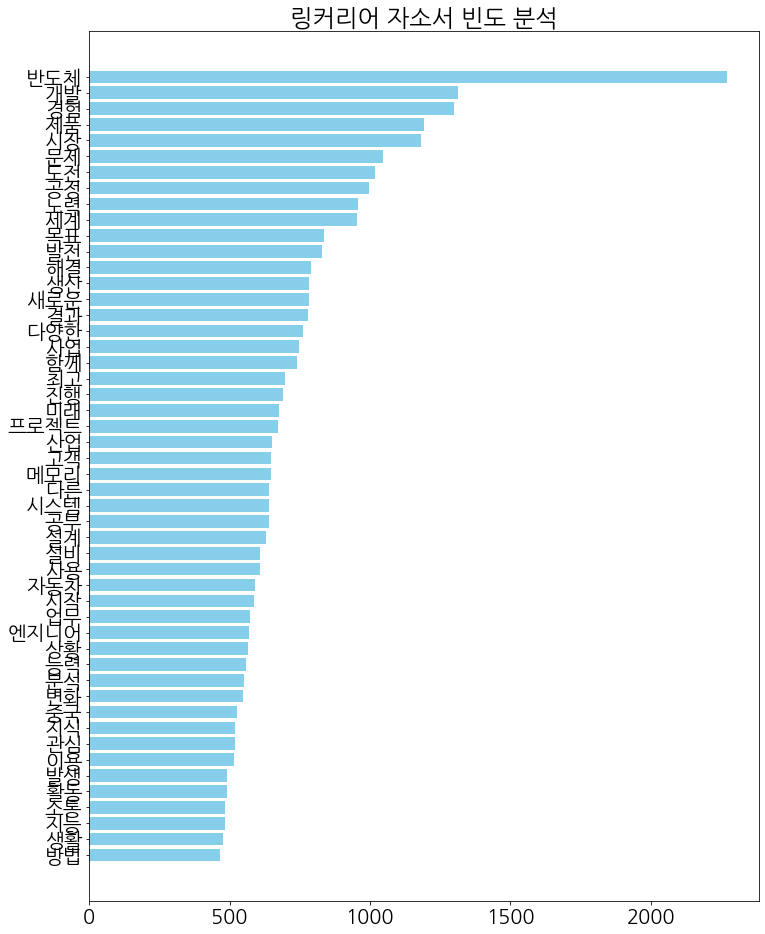

In [71]:
stop_words_1word = ['최근', '사회', '이슈', '중요하다고', '생각', '회사', '입사', '견해', '기술', '바랍니다', '시기', '선택', '하십시오',
              '영향', '끼친', '시간', '인물', '간략히', '본인', '성장', '과정', '가장', '한가지', '현재', '포함', '하시기', '바랍니다',
              '가상', '작품', '취업', '이유', '있다고', '이루고', '삼성', '전자', '자신', '사건', '위해', '하기', '되는', '하게', '되었습니다',
              '때문', '입니다', '하여', '지원', '한다고', '합니다', '하지', '않고', '이내', '싶은', '이를', '있을', '입니다', '되고', '싶습니다',
              '이기', '때문', '있습니다', '이러한', '많은', '사람', '하지만', '모습', '기업', '또한', '구체', '서술',
              '삼', '성', '전자', '지원', '이유', '후', '입사', '회사', '이루고', '싶은', '꿈', '자', '이내', '기술', '하십시오',
              '가', '하는', '이', '하기로', '차', '수', '있었던', '생각', '입니다', '합니다', '하여', '있습니다', '했습니다', '있는',
              '삼성', '통해', '위해', '사람', '하는', '했습니다', '있는', '통해', '대한', '있었습니다', '하였습니다', '하며', '가지',
              '분야', '대해', '그리고', '하면서', '해야', '하는', '했습니다', '아니라', '하고', '되어', '이었습니다', '같은', '관련', '바탕']
count_vec_1word = CountVectorizer(
    stop_words=stop_words_1word,
    min_df = 100,
    max_features = 100,
    ngram_range = (1,1)
)

_word1, _vec1 = count_analyze(prepro_text_for_count, count_vec_1word, 50, 'skyblue', '링커리어 자소서')

In [72]:
cosine_df_1word = cosine_extraction(count_vec_1word, prepro_text_for_count, use_df[['성명', '전체 자소서']], _word1)
cosine_df_1word

,성명,삼성 코사인 유사도,rank
6,곽다희,0.514882,1
54,이미숙,0.492494,2
33,조희란,0.436695,3
37,도주연,0.429396,4
7,이성빈,0.425195,5
...,...,...,...
62,성경학,0.000000,76
57,임승혁,0.000000,76
65,정기택,0.000000,76
58,홍현승,0.000000,76


## 2 word

['문제 발생', '추구 하는', '목표 달성', '구체 서술', '다양한 분야', '노력 하겠습니다', '얻을 있었습니다', '제공 하는', '배울 있었습니다', '제품 개발', '과목 수강', '시장 선도', '대한 관심', '경험 바탕', '계속 해서', '노력 하는', '하는 자세', '사용 하는', '발생 하는', '도전 정신', '노력 했습니다', '반도체 생산', '개발 하는', '프로젝트 진행', '엔지니어 로서', '반도체 분야', '도전 하는', '반도체 산업', '시작 했습니다', '세계 최고', '메모리 사업', '시스템 반도체', '반도체 공정', '경험 통해', '설비 엔지니어', '반도체 시장', '메모리 반도체', '문제 해결', '자율 주행', '인공 지능']
[66, 67, 68, 69, 69, 70, 72, 73, 73, 73, 74, 74, 74, 75, 77, 77, 79, 80, 83, 89, 93, 97, 104, 105, 108, 115, 116, 116, 121, 124, 127, 151, 170, 176, 193, 212, 227, 252, 320, 436]


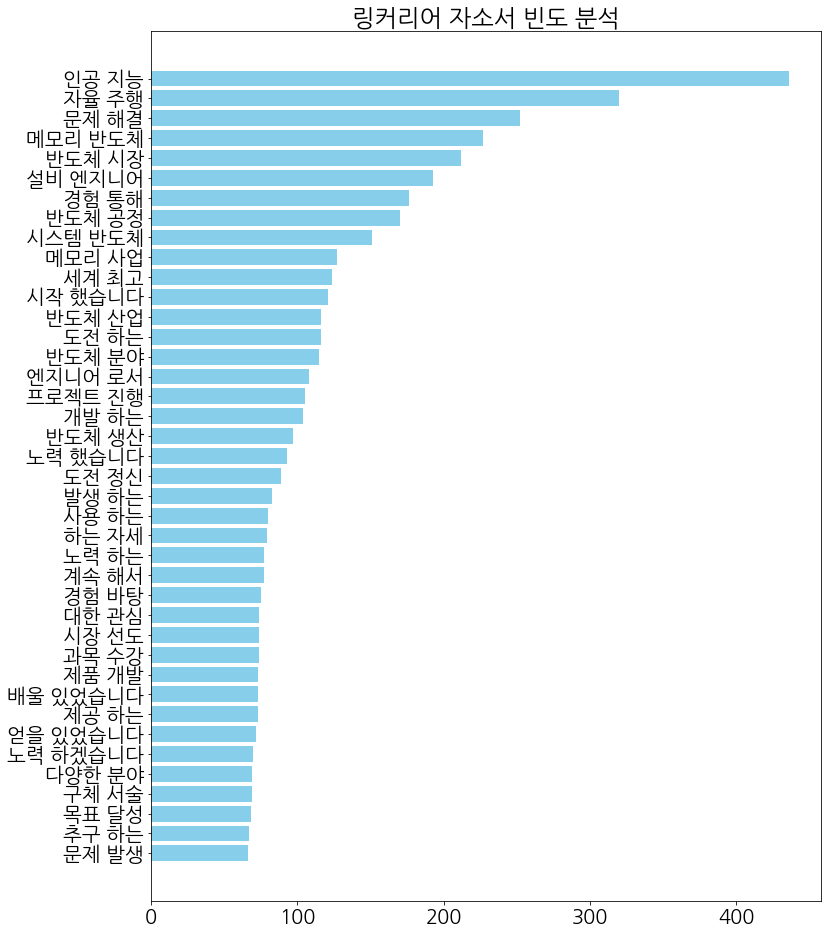

In [21]:
stop_words = ['최근', '사회', '이슈', '중요하다고', '생각', '회사', '입사', '견해', '기술', '바랍니다', '시기', '선택', '하십시오',
              '영향', '끼친', '시간', '인물', '간략히', '본인', '성장', '과정', '가장', '한가지', '현재', '포함', '하시기', '바랍니다',
              '가상', '작품', '취업', '이유', '있다고', '이루고', '삼성', '전자', '자신', '사건', '위해', '하기', '되는', '하게', '되었습니다',
              '때문', '입니다', '하여', '지원', '한다고', '합니다', '하지', '않고', '이내', '싶은', '이를', '있을', '입니다', '되고', '싶습니다',
              '이기', '때문', '있습니다', '이러한', '많은', '사람', '하지만', '모습', '기업', '또한', '구체', '서술',  ]
count_vec = CountVectorizer(
    stop_words=stop_words,
    min_df = 50,
    max_features = 40,
    ngram_range = (2,2)
)

_word, _vec = count_analyze(prepro_text_for_count, count_vec, 40, 'skyblue', '링커리어 자소서')

In [57]:
use_df[['성명', '전체 자소서']]

,성명,전체 자소서
0,오탁근,저 업무 하는 데 있어서 꼼꼼하게 일 처리 것 선호 하며 실제 도 업무 처리 꼼꼼하...
1,고수민,개발자 취업 하기 위해 및 각종 클라우드 서비스 서버 대해 독학 및 학원 준비 했습...
2,이태준,업무 강점 프로그램 활용 및 전화 및 고객 응대 업무 등 입니다저 년 인천 출생 하...
3,정찬일,홍보 분야 무엇 소위 트랜드 민감해야 합니다 내부 우리 아닌 외부 타인 시선 의식 ...
4,최현진,군대 만 기 전역 후 서비스 직 시작 하면서 어려 종류 사람 무수 히 많이 만나면서...
...,...,...
75,이윤효,어릴 때 미술 전공 해왔던 탓 기본 여러 가지 테크닉 그림 그릴 수 있습니다 또한 ...
76,김혜진,어릴 적 부모님 하신 말씀 절대 놓치지 않았던 노하우 언어 가르침 이었습니다 무엇 ...
77,허수현,사람 우선 시 하는 회사 생각 합니다 검색 중 유투브 클립 대표 경 영 철학 접 이...
78,위승희,다른 사람 보지 못 하는 가능성 보고 그것 실현 하고자 노력 하는 회사 또한 그리스...


In [62]:
cosine_df = cosine_extraction(count_vec, prepro_text_for_count, use_df[['성명', '전체 자소서']], _word)
cosine_df

,성명,삼성 코사인 유사도,rank
48,김인집,0.394676,1
50,이승수,0.387298,2
6,곽다희,0.365148,3
7,이성빈,0.353553,4
40,김한나,0.316228,5
...,...,...,...
46,최정원,0.000000,61
9,정난애,0.000000,61
20,김영인,0.000000,61
51,이주원,0.000000,61


In [64]:
cosine_df.to_csv('./삼성 fit 유사도.csv', encoding='utf-8-sig')

# 연관어 분석

## Word2Vec 기반 연관어 분석
- 참고 : Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델입니다. 우선 적당하게 데이터를 나열해주면 Word2vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어입니다.

In [ ]:
new_texts = [x for x in analysis_data.values ]

# sg=0 : CBOW, sg=1 : Skip-gram.
# window=2 : 중심단어로부터 좌우 2개 단어까지 학습 적용
# min_count=3 : 전체 문서에서 최소 3번 이상 출현한 단어들로 학습 진행
model = Word2Vec(new_texts, sg=1, window=2, min_count=3)

model

In [ ]:
# Word2Vec 임베딩 행렬 크기
# (9807, 100) ==> 총 9,807개의 단어가 존재하며 각 단어는 100차원으로 구성!
model.wv.vectors.shape

(9807, 100)

In [ ]:
# 두 단어간 유사도 확인
model.similarity('노력', '직무') # ==> 0.4238115
model.similarity('성과', '운')  # ==> 0.5904772
model.similarity('데이터', '지능') # ==> 0.56477046


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.


0.56477046

In [ ]:
# 한 단어의 벡터 출력
# '우수'
model['우수'] # ==> 100개의 벡터값이 나옴

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([-0.002539  , -0.06057164, -0.21171942, -0.1135043 , -0.02038069,
       -0.11256956,  0.02739452, -0.14090475,  0.03007646,  0.23465586,
       -0.17316961,  0.41919255, -0.09107862,  0.09444676, -0.05774161,
        0.1845567 ,  0.19271594, -0.06102462, -0.15735976,  0.11052014,
       -0.07309107, -0.22131294, -0.257398  , -0.01043399,  0.18507005,
       -0.08730992, -0.00072695,  0.09098671,  0.03224645, -0.09390066,
        0.15575832, -0.02193078, -0.21297002,  0.05585172, -0.13468964,
        0.2613472 , -0.27466497,  0.16083005, -0.22486125, -0.11347666,
       -0.07764699, -0.05525779, -0.02436115,  0.18342403, -0.07581959,
       -0.29773   , -0.03689386,  0.24037196,  0.1358245 , -0.13924715,
        0.06381249,  0.31632203, -0.22355069, -0.00261679, -0.2361036 ,
       -0.1768923 ,  0.19399948,  0.10332637, -0.17251067, -0.17183083,
        0.22672218,  0.20263378, -0.04204553, -0.03017035,  0.27352262,
        0.17141138, -0.02135423,  0.2246755 ,  0.00305618, -0.00

In [ ]:
# 성공이란 단어와 연관 높은
model.wv.most_similar('성공')

[('이루어', 0.8150209784507751),
 ('냈습니다', 0.7964283227920532),
 ('마쳤습니다', 0.78409743309021),
 ('이끌어', 0.7834421396255493),
 ('내고', 0.7714000940322876),
 ('장기간', 0.7700888514518738),
 ('최종', 0.7693543434143066),
 ('이뤄', 0.7674574255943298),
 ('공동', 0.7673068046569824),
 ('해보거나', 0.7667516469955444)]

## 통계적 가중치 기반
- from scipy import sparse

## 동시 출현 기반 연관어 분석